In [1]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

# Read the data into a dataframe
df = pd.read_csv("cleaned_sentiment_data.csv")

# Separate the features and target variable
X = df[
    [
        "total_positive_direct_mentions",
        "total_negative_direct_mentions",
        "total_positive_indirect_mentions",
        "total_negative_indirect_mentions",
        "soft_cap",
    ]
]
y = df["ico_success"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [2]:
X_train

,total_positive_direct_mentions,total_negative_direct_mentions,total_positive_indirect_mentions,total_negative_indirect_mentions,soft_cap
448,424,596,2619,9565,9800000.0
335,2741,5814,23647,52311,110000.0
294,3653,3267,41936,16493,500000.0
684,597,355,1675,2486,17540000.0
79,390,376,3219,3555,200000.0
...,...,...,...,...,...
71,2501,1510,3347,1148,2480000.0
106,2994,3284,97209,52331,14800000.0
270,466,222,899,2764,1720000.0
435,9362,8364,101679,79251,2400000.0


In [3]:
X_test

,total_positive_direct_mentions,total_negative_direct_mentions,total_positive_indirect_mentions,total_negative_indirect_mentions,soft_cap
196,237,151,1618,1568,350000.0
299,3464,1743,8669,15029,200000.0
744,115,54,1118,1863,14380000.0
227,1172,1355,20919,16599,2400000.0
541,748,1210,3870,2234,20000000.0
...,...,...,...,...,...
442,831,283,4608,2724,20000000.0
760,1990,1897,19376,16358,600000.0
714,505,352,2003,5676,30000000.0
666,4804,1976,54022,90326,30000000.0


# Neural Network

To get started, we use a very simple classification problem and a very simple multi-layer perceptron architecture.

## Imports

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.datasets import make_classification
from torch import nn

from skorch import NeuralNetClassifier
from skorch.helper import SkorchDoctor

In [5]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)

In [6]:
plt.style.use("seaborn-v0_8")

## Load data

In [7]:
X, y = X_train.to_numpy().astype(np.float32), y_train.to_numpy().astype(np.int64)
X_test, y_test = X_test.to_numpy().astype(np.float32), y_test.to_numpy().astype(
    np.int64
)

In [8]:
X.shape, y.shape, y.mean()

((652, 5), (652,), 0.7285276073619632)

### Definition of the `PyTorch` classification `module`

This is just an MLP with two hidden layers.

In [38]:
class ClassifierModule(nn.Module):

    def __init__(
        self,
        num_features=5,
        num_units=1024,
        n_classes=2,
        nonlin=F.relu,
        dropout=0.1,
        depth=2,
        batchnorm=True,
    ):
        super(ClassifierModule, self).__init__()
        self.num_features = num_features
        self.num_units = num_units
        self.n_classes = n_classes
        self.nonlin = nonlin
        self.batchnorm = batchnorm
        self.depth = depth

        self.dense0 = nn.Linear(self.num_features, self.num_units)
        self.nonlin = self.nonlin
        self.dropout = nn.Dropout(dropout)

        layers = []
        for i in range(1, self.depth):
            layers.append(nn.Linear(self.num_units, self.num_units))
        self.dense1 = nn.Sequential(*layers)

        self.output = nn.Linear(self.num_units, self.n_classes)
        self.bn = nn.BatchNorm1d(self.n_classes)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.dropout(X)
        X = self.nonlin(self.dense1(X))
        X = self.output(X)

        if self.batchnorm:
            X = self.bn(X)

        X = F.softmax(X, dim=-1)
        return X

In [10]:
device = (
    torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
)  # use gpu

device

device(type='cuda')

In [22]:
net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=50,
    lr=0.01,
    batch_size=32,
    device=device,

    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

In [24]:
%%time

from sklearn.model_selection import GridSearchCV

# deactivate skorch-internal train-valid split and verbose logging
net.set_params(train_split=False, verbose=0)
params = {
    "lr": [0.001, 0.01],
    'batch_size': [10, 20, 40],
    'max_epochs': [10, 20],
    "module__batchnorm": [False, True],
    "module__num_units": list(range(10, 101, 10)),
    "module__dropout": [i * 0.1 for i in range(6)],
}
gs = GridSearchCV(net, params, refit=False, cv=3, n_jobs=-1, verbose=1, scoring="accuracy")

grid_result = gs.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 1440 candidates, totalling 4320 fits


/home/inflaton/miniconda3/envs/ico/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best: 0.736172 using {'batch_size': 40, 'lr': 0.001, 'max_epochs': 20, 'module__batchnorm': True, 'module__dropout': 0.30000000000000004, 'module__num_units': 60}
0.424407 (0.202798) with: {'batch_size': 10, 'lr': 0.001, 'max_epochs': 10, 'module__batchnorm': False, 'module__dropout': 0.0, 'module__num_units': 10}
0.577989 (0.213187) with: {'batch_size': 10, 'lr': 0.001, 'max_epochs': 10, 'module__batchnorm': False, 'module__dropout': 0.0, 'module__num_units': 20}
0.423547 (0.215359) with: {'batch_size': 10, 'lr': 0.001, 'max_epochs': 10, 'module__batchnorm': False, 'module__dropout': 0.0, 'module__num_units': 30}
nan (nan) with: {'batch_size': 10, 'lr': 0.001, 'max_epochs': 10, 'module__batchnorm': False, 'module__dropout': 0.0, 'module__num_units': 40}
0.271474 (0.000588) with: {'batch_size': 10, 'lr': 0.001, 'max_epochs': 10, 'module__batchnorm': False, 'module__dropout': 0.0, 'module__num_units': 50}
0.271474 (0.000588) with: {'batch_size': 10, 'lr': 0.001, 'max_epochs': 10, 'modul

/home/inflaton/miniconda3/envs/ico/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
1 fits failed out of a total of 4320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/inflaton/miniconda3/envs/ico/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/inflaton/miniconda3/envs/ico/lib/python3.11/site-packages/skorch/classifier.py", line 165, in fit
    return super(NeuralNetClassifier, self).fit(X, y, **fit_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/inflat

In [25]:
%%time

from sklearn.model_selection import GridSearchCV

# deactivate skorch-internal train-valid split and verbose logging
net.set_params(train_split=False, verbose=0)
params = {
    "lr": [0.001, 0.01],
    'batch_size': [20, 40, 60],
    'max_epochs': [10, 20],
    "module__batchnorm": [False, True],
    "module__num_units": list(range(50, 101, 2)),
    "module__dropout": [i * 0.1 for i in range(6)],
}
gs = GridSearchCV(net, params, refit=False, cv=3, n_jobs=-1, verbose=1, scoring="accuracy")

grid_result = gs.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 3744 candidates, totalling 11232 fits


/home/inflaton/miniconda3/envs/ico/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best: 0.737715 using {'batch_size': 40, 'lr': 0.001, 'max_epochs': 20, 'module__batchnorm': True, 'module__dropout': 0.5, 'module__num_units': 56}
nan (nan) with: {'batch_size': 20, 'lr': 0.001, 'max_epochs': 10, 'module__batchnorm': False, 'module__dropout': 0.0, 'module__num_units': 50}
0.576453 (0.215359) with: {'batch_size': 20, 'lr': 0.001, 'max_epochs': 10, 'module__batchnorm': False, 'module__dropout': 0.0, 'module__num_units': 52}
0.271474 (0.000588) with: {'batch_size': 20, 'lr': 0.001, 'max_epochs': 10, 'module__batchnorm': False, 'module__dropout': 0.0, 'module__num_units': 54}
0.571872 (0.208978) with: {'batch_size': 20, 'lr': 0.001, 'max_epochs': 10, 'module__batchnorm': False, 'module__dropout': 0.0, 'module__num_units': 56}
0.576453 (0.215359) with: {'batch_size': 20, 'lr': 0.001, 'max_epochs': 10, 'module__batchnorm': False, 'module__dropout': 0.0, 'module__num_units': 58}
nan (nan) with: {'batch_size': 20, 'lr': 0.001, 'max_epochs': 10, 'module__batchnorm': False, 'mod

/home/inflaton/miniconda3/envs/ico/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
3 fits failed out of a total of 11232.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/inflaton/miniconda3/envs/ico/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/inflaton/miniconda3/envs/ico/lib/python3.11/site-packages/skorch/classifier.py", line 165, in fit
    return super(NeuralNetClassifier, self).fit(X, y, **fit_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/infla

In [13]:
%%time

from sklearn.model_selection import GridSearchCV
net = NeuralNetClassifier(
    ClassifierModule,
    lr=0.001,
    device=device,

    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

# deactivate skorch-internal train-valid split and verbose logging
net.set_params(train_split=False, verbose=0)

params = {
    'batch_size': [20, 40, 60],
    'max_epochs': [10, 20],
    "module__num_units": list(range(50, 101, 2)),
    "module__depth": list(range(2, 9)),
    "module__dropout": [i * 0.1 for i in range(6)],
}

gs = GridSearchCV(net, params, refit=False, cv=3, n_jobs=-1, verbose=1, scoring="accuracy")

grid_result = gs.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 6552 candidates, totalling 19656 fits


/home/inflaton/miniconda3/envs/ico/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/inflaton/miniconda3/envs/ico/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
1 fits failed out of a total of 19656.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/inflaton/miniconda3/envs/ico/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_par

Best: 0.737715 using {'batch_size': 20, 'max_epochs': 10, 'module__depth': 6, 'module__dropout': 0.4, 'module__num_units': 66}
0.593357 (0.184951) with: {'batch_size': 20, 'max_epochs': 10, 'module__depth': 2, 'module__dropout': 0.0, 'module__num_units': 50}
0.598550 (0.179978) with: {'batch_size': 20, 'max_epochs': 10, 'module__depth': 2, 'module__dropout': 0.0, 'module__num_units': 52}
0.581181 (0.156694) with: {'batch_size': 20, 'max_epochs': 10, 'module__depth': 2, 'module__dropout': 0.0, 'module__num_units': 54}
0.603137 (0.173491) with: {'batch_size': 20, 'max_epochs': 10, 'module__depth': 2, 'module__dropout': 0.0, 'module__num_units': 56}
0.599543 (0.160493) with: {'batch_size': 20, 'max_epochs': 10, 'module__depth': 2, 'module__dropout': 0.0, 'module__num_units': 58}
0.704054 (0.030819) with: {'batch_size': 20, 'max_epochs': 10, 'module__depth': 2, 'module__dropout': 0.0, 'module__num_units': 60}
nan (nan) with: {'batch_size': 20, 'max_epochs': 10, 'module__depth': 2, 'module_

## Use skorch doctor

So far, everything we did was just as you would always proceed when working with PyTorch and skorch. Next step, however, is where `SkorchDoctor` enters the picture. We wrap the `net` inside the `SkorchDoctor` class. This wrapper class takes care of adding a bunch of hooks to the PyTorch module that enable us to collect important data.

In [14]:
best_params = {
    "batch_size": 20,
    "max_epochs": 10,
    "module__depth": 6,
    "module__dropout": 0.4,
    "module__num_units": 66,
}

In [39]:
best_net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=10,
    lr=0.001,
    batch_size=20,
    module__depth=6,
    module__num_units=66,
    module__dropout=0.4,
    device=device,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

In [40]:
doctor = SkorchDoctor(best_net)

### Train the doctor

The `SkorchDoctor` instance itself can be used like any ordinary estimator, i.e. you can fit it, call `predict` on it etc. For us to study the training process, we need to fit the instance with our training data. However, it is recommended to use only a very small amount of data, like 100 samples, and train for a small number of epochs, like 5 in this example:

In [41]:
doctor.fit(X[:640], y[:640])

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8325       0.7266        0.8011  0.2066
      2        0.7430       0.3984        0.8035  0.1841
      3        0.6923       0.7266        0.7084  0.1722
      4        0.6868       0.7422        0.6706  0.1776
      5        0.6965       0.7578        0.6718  0.1695
      6        0.6858       0.7578        0.6654  0.1700
      7        0.6860       0.7500        0.6600  0.1596
      8        0.6783       0.7266        0.6807  0.1591
      9        0.6696       0.7266        0.7163  0.1667
     10        0.6689       0.7422        0.6623  0.1590


(0.65, 0.85)

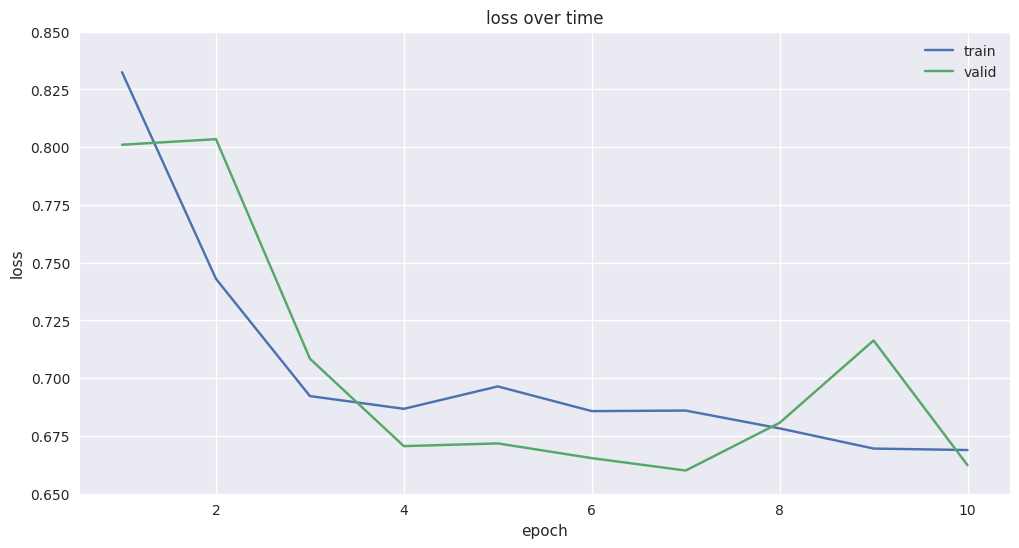

In [42]:
_, ax = plt.subplots(figsize=(12, 6))
doctor.plot_loss(ax=ax)
ax.set_ylim([0.65, 0.85])